# Week 6 - Decision Trees on Real Data

Now that we are pros with decision trees, we can try applying them on a real data set.


### Datset
We will be using a dataset of sites in Eastern Africa spanning 5000 BCE to 1800 CE.

The dataset can be downloaded here:
(Note: For some reason the csv file is causing errors for the pandas import, so download the excel version)
https://pandoradata.earth/dataset/wanyika


The associated publication is:

Victor Iminjili, https://www.doi.org/10.48493/mwsp-e133 (compiled from many separte publications, as shown in the file)

In [57]:
# import required libraries
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier 
import seaborn as sns

Now let's import the Excel file and inspect the data

In [58]:
# If necessary
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [111]:
# load site data
df_raw = pd.read_excel('./wanyika-chronological-database-in-excel-format.xlsx')

# have a quick look at the data 
df_raw.head()

,Entry ID,Site ID,Site Name,Country,Country Region,Vegetation Cover,Latitude,Longitude,Trench/Site Notes,Context,...,Reference 1,DOI Reference 1,Reference 2,DOI Reference 2,Reference 3,DOI Reference 3,Reference 4,DOI Reference 4,Reference 5,DOI Reference 5
0,1,1,Kabusanze,Rwanda,Rwanda,Forest/wood/grassland mosaic,-2.659455,29.620696,BPS36,Pit fill,...,"Giblin, J., & Fuller, D. (2011). First and sec...",DOI:10.1007/s00334-011-0288-0,"Giblin, J. D. (2008). New Work on the Later Ar...",https://www.academia.edu/813429/New_work_on_th...,"Giblin, J., & Humphris, J. (2010). An Urewe bu...",https://doi.org/10.1080/0067270X.2010.521677,NaN,NaN,"Giblin, J. D. (2010). Re-constructing the past...",https://doi.org/10.1080/0067270X.2010.521680
1,2,1,Kabusanze,Rwanda,Rwanda,Forest/wood/grassland mosaic,-2.659455,29.620696,BPS36,Burial fill,...,"Giblin, J., & Fuller, D. (2011). First and sec...",DOI:10.1007/s00334-011-0288-0,"Giblin, J. D. (2008). New Work on the Later Ar...",https://www.academia.edu/813429/New_work_on_th...,"Giblin, J., & Humphris, J. (2010). An Urewe bu...",https://doi.org/10.1080/0067270X.2010.521678,NaN,NaN,"Giblin, J. D. (2010). Re-constructing the past...",https://doi.org/10.1080/0067270X.2010.521680
2,3,1,Kabusanze,Rwanda,Rwanda,Forest/wood/grassland mosaic,-2.659455,29.620696,BPS36,Pit fill,...,"Giblin, J., & Fuller, D. (2011). First and sec...",DOI:10.1007/s00334-011-0288-0,"Giblin, J. D. (2008). New Work on the Later Ar...",https://www.academia.edu/813429/New_work_on_th...,"Giblin, J., & Humphris, J. (2010). An Urewe bu...",https://doi.org/10.1080/0067270X.2010.521679,NaN,NaN,"Giblin, J. D. (2010). Re-constructing the past...",https://doi.org/10.1080/0067270X.2010.521680
3,4,2,Masangano,Rwanda,Rwanda,Forest/wood/grassland mosaic,-1.687612,29.881758,MSG,Occupation deposit,...,"Giblin, J., & Fuller, D. (2011). First and sec...",DOI:10.1007/s00334-011-0288-0,"Giblin, J. D. (2008). New Work on the Later Ar...",https://www.academia.edu/813429/New_work_on_th...,NaN,NaN,NaN,NaN,"Giblin, J. D. (2010). Re-constructing the past...",https://doi.org/10.1080/0067270X.2010.521680
4,5,3,Karama,Rwanda,Rwanda,Forest/wood/grassland mosaic,-1.929041,29.841008,GPS014,Pit fill,...,"Giblin, J., & Fuller, D. (2011). First and sec...",DOI:10.1007/s00334-011-0288-0,"Giblin, J. D. (2008). New Work on the Later Ar...",https://www.academia.edu/813429/New_work_on_th...,NaN,NaN,NaN,NaN,"Giblin, J. D. (2010). Re-constructing the past...",https://doi.org/10.1080/0067270X.2010.521680


In [127]:
import numpy as np
np.median(df_raw['range'].tolist())

np.float64(270.0)

## Let's try to make a system that can classify a site by country
##### First let's see how many sites we have for each country.

In [60]:
from collections import Counter
Counter(df_raw['Country'])

Counter({'Madagascar': 677,
         'Kenya': 668,
         'Tanzania': 389,
         'Comoros': 26,
         'Rwanda': 20,
         'Tanzania ': 12})

We see they are very imbalanced. We also have duplicate Tanzania labels with a space at the end. We'll get back to this both of these things later

In [61]:
# Let's see our columns
columns = df_raw.columns
for i in range(len(columns)):
    print(str(i) + ' ' + columns[i])

0 Entry ID
1 Site ID
2 Site Name 
3 Country
4 Country Region
5 Vegetation Cover  
6 Latitude
7 Longitude
8 Trench/Site Notes 
9 Context
10 Date Type
11 Labcode
12 Date BP
13 Date BP SD
14 Min Chronology (Calibrated BCE/CE) 
15 Max Chronology  (Calibrated BCE/CE)
16 Mean Chronology  (Calibrated BCE/CE) 
17 Min Chronology (Calibrated BP - 1950)
18 Max Chronology  (Calibrated BP - 1950)
19 Mean Chronology  (Calibrated BP - 1950) 
20 Dated Material
21 Dated Taxon
22 Indet Millet
23 Finger Millet (Eleusine coracana)
24 Pearl Millet (Pennisetum glaucum)
25 Sorghum (Sorghum bicolor)
26 Lablab (Lablab purpureus)
27 Vigna sp.
28 Mung Bean (Vigna radiata)
29 Cowpea (Vigna unguiculata)
30 Rice (Oryza sativa)
31 Peas (Pisum)
32 Triticoid
33 Wheat (Triticum sp.) 
34 Legumes Beans?
35 Red Dates (Ziziphus jujuba)
36 Indet. Nuts
37 Coconuts (Cocos nucifera)
38 Fig (Ficus sp.) 
39 Baobab (Adansonia digitata)
40 Cotton (Gossypium sp.)
41 Other
42 Wild Terrestrial Fauna 
43 Avian Fauna 
44 Aquatic Fauna


In [62]:
# There are a loooot of columns we can drop

df_raw = df_raw.drop(columns = [columns[i] for i in [0,1,2,4,6,7,8,9,10,11,12,13,14,15,16,17,18,20,21,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74]])

In [63]:
# Let's look at the unique items for the columns

for column in df_raw.columns:
    print('-------')
    print(column)
    print("Set size: " + str(len(df_raw[column].unique())))
    print(df_raw[column].unique())

-------
Country
Set size: 6
['Rwanda' 'Kenya' 'Tanzania' 'Tanzania ' 'Comoros' 'Madagascar']
-------
Vegetation Cover  
Set size: 6
['Forest/wood/grassland mosaic ' 'Coastal forest mosaic '
 'Dry northern wooded grassland' 'Montane forest'
 'Dry southern wooded grassland ' 'Dry coastal wooded grassland']
-------
Mean Chronology  (Calibrated BP - 1950) 
Set size: 1457
[1470.  1475.5 1562.5 ...  595.   607.5  607. ]
-------
Indet Millet
Set size: 2
[nan 'Yes']
-------
Finger Millet (Eleusine coracana)
Set size: 2
[nan 'Yes']
-------
Pearl Millet (Pennisetum glaucum)
Set size: 2
['Yes' nan]
-------
Sorghum (Sorghum bicolor)
Set size: 2
['Yes' nan]
-------
Lablab (Lablab purpureus)
Set size: 2
[nan 'Yes']
-------
Vigna sp.
Set size: 2
['Yes' nan]
-------
Mung Bean (Vigna radiata)
Set size: 2
[nan 'Yes']
-------
Cowpea (Vigna unguiculata)
Set size: 2
['Yes' nan]
-------
Rice (Oryza sativa)
Set size: 3
[nan 'Yes' 'Yes ']
-------
Peas (Pisum)
Set size: 2
[nan 'Yes']
-------
Triticoid
Set size

In [64]:
df_raw = df_raw.drop(columns=['Triticoid','Ceramic Phase (Pottery Ware)','Other'])

In [65]:
# We notice there are a lot of problems where features have unnecessary spaces, capitalization, or question marks
# Let's fix this

df_raw = df_raw.apply(lambda x: x.str.replace(' ','').str.replace('?','').str.lower() if x.dtype == "object" else x)


In [66]:
# Let's take another look now

for column in df_raw.columns:
    print('-------')
    print(column)
    print("Set size: " + str(len(df_raw[column].unique())))
    print(df_raw[column].unique())

# Looks better!

-------
Country
Set size: 5
['rwanda' 'kenya' 'tanzania' 'comoros' 'madagascar']
-------
Vegetation Cover  
Set size: 6
['forest/wood/grasslandmosaic' 'coastalforestmosaic'
 'drynorthernwoodedgrassland' 'montaneforest' 'drysouthernwoodedgrassland'
 'drycoastalwoodedgrassland']
-------
Mean Chronology  (Calibrated BP - 1950) 
Set size: 1457
[1470.  1475.5 1562.5 ...  595.   607.5  607. ]
-------
Indet Millet
Set size: 2
[nan 'yes']
-------
Finger Millet (Eleusine coracana)
Set size: 2
[nan 'yes']
-------
Pearl Millet (Pennisetum glaucum)
Set size: 2
['yes' nan]
-------
Sorghum (Sorghum bicolor)
Set size: 2
['yes' nan]
-------
Lablab (Lablab purpureus)
Set size: 2
[nan 'yes']
-------
Vigna sp.
Set size: 2
['yes' nan]
-------
Mung Bean (Vigna radiata)
Set size: 2
[nan 'yes']
-------
Cowpea (Vigna unguiculata)
Set size: 2
['yes' nan]
-------
Rice (Oryza sativa)
Set size: 2
[nan 'yes']
-------
Peas (Pisum)
Set size: 2
[nan 'yes']
-------
Wheat (Triticum sp.) 
Set size: 2
[nan 'yes']
-------

In [67]:
# Let's check what percentage of the columns are empty (NaN values) using the "isna" method

length = len(df_raw)

for column in df_raw.columns:
    percent_NaN = df_raw[column].isna().sum()/length*100
    print('-------')
    print(column)
    print(percent_NaN)

-------
Country
0.0
-------
Vegetation Cover  
0.0
-------
Mean Chronology  (Calibrated BP - 1950) 
0.0
-------
Indet Millet
99.83258928571429
-------
Finger Millet (Eleusine coracana)
97.82366071428571
-------
Pearl Millet (Pennisetum glaucum)
99.38616071428571
-------
Sorghum (Sorghum bicolor)
98.10267857142857
-------
Lablab (Lablab purpureus)
99.83258928571429
-------
Vigna sp.
99.72098214285714
-------
Mung Bean (Vigna radiata)
99.72098214285714
-------
Cowpea (Vigna unguiculata)
99.33035714285714
-------
Rice (Oryza sativa)
98.93973214285714
-------
Peas (Pisum)
99.77678571428571
-------
Wheat (Triticum sp.) 
99.94419642857143
-------
Legumes Beans?
99.94419642857143
-------
Red Dates (Ziziphus jujuba)
99.94419642857143
-------
Indet. Nuts
99.49776785714286
-------
Coconuts (Cocos nucifera)
99.44196428571429
-------
Fig (Ficus sp.) 
99.94419642857143
-------
Baobab (Adansonia digitata)
99.27455357142857
-------
Cotton (Gossypium sp.)
99.609375
-------
Wild Terrestrial Fauna 
51.4

In [68]:
# A lot of the columns are nearly empty. There isn't a "right answer" for how to deal with this.
# Here, for simplicity's sake, let's cull any of them with over 95% NaN

length = len(df_raw)

for column in df_raw.columns:
    percent_NaN = df_raw[column].isna().sum()/length*100
    if percent_NaN > 95:
        df_raw = df_raw.drop(columns=[column])

In [69]:
# Switch "NaN/yes" to "0,1"

df_raw = df_raw.fillna(0).replace('yes',1)

C:\Users\re72fam\AppData\Local\Temp\ipykernel_24864\3992631212.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_raw = df_raw.fillna(0).replace('yes',1)


In [70]:
# "Vegetation Cover" is a categorical column (multiple unrelated labels). We can one-hot-encode it using the "get_dummies" command

df_raw = pd.get_dummies(df_raw, columns=['Vegetation Cover  '], dtype=int, prefix='', prefix_sep='')

In [71]:
df_raw.keys()

Index(['Country', 'Mean Chronology  (Calibrated BP - 1950) ',
       'Wild Terrestrial Fauna ', 'Avian Fauna ', 'Aquatic Fauna',
       'Indet. Bones', 'Bovids', 'Cattle (Bos taurus/indicus)',
       'Sheep/Goat (Ovis/Capra Indet.)', 'Iron Smelting', 'Iron Use',
       'Ceramics', 'coastalforestmosaic', 'drycoastalwoodedgrassland',
       'drynorthernwoodedgrassland', 'drysouthernwoodedgrassland',
       'forest/wood/grasslandmosaic', 'montaneforest'],
      dtype='object')

In [72]:
df_raw.head()

,Country,Mean Chronology (Calibrated BP - 1950),Wild Terrestrial Fauna,Avian Fauna,Aquatic Fauna,Indet. Bones,Bovids,Cattle (Bos taurus/indicus),Sheep/Goat (Ovis/Capra Indet.),Iron Smelting,Iron Use,Ceramics,coastalforestmosaic,drycoastalwoodedgrassland,drynorthernwoodedgrassland,drysouthernwoodedgrassland,forest/wood/grasslandmosaic,montaneforest
0,rwanda,1470.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,rwanda,1475.5,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0
2,rwanda,1562.5,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,rwanda,1608.5,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,rwanda,1193.5,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0


In [73]:
# Save our final cleaned DataFrame
df = df_raw

## Studying Feature Correlations

In [74]:
# Before starting ML it's a good idea to try to visualize our data a bit to see which features show strong correlations for each class to be predicted (country in our case)

df_countries = pd.get_dummies(df_raw, columns=['Country'], dtype=int, prefix='', prefix_sep='')

In [75]:
df_countries.head()

,Mean Chronology (Calibrated BP - 1950),Wild Terrestrial Fauna,Avian Fauna,Aquatic Fauna,Indet. Bones,Bovids,Cattle (Bos taurus/indicus),Sheep/Goat (Ovis/Capra Indet.),Iron Smelting,Iron Use,...,drycoastalwoodedgrassland,drynorthernwoodedgrassland,drysouthernwoodedgrassland,forest/wood/grasslandmosaic,montaneforest,comoros,kenya,madagascar,rwanda,tanzania
0,1470.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,1475.5,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
2,1562.5,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,1608.5,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,1193.5,1,0,0,0,1,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [ ]:
# Let's save this for later use (we'll use it next week)
df_countries.to_csv("Wanyika_cleaned.csv", index=False)

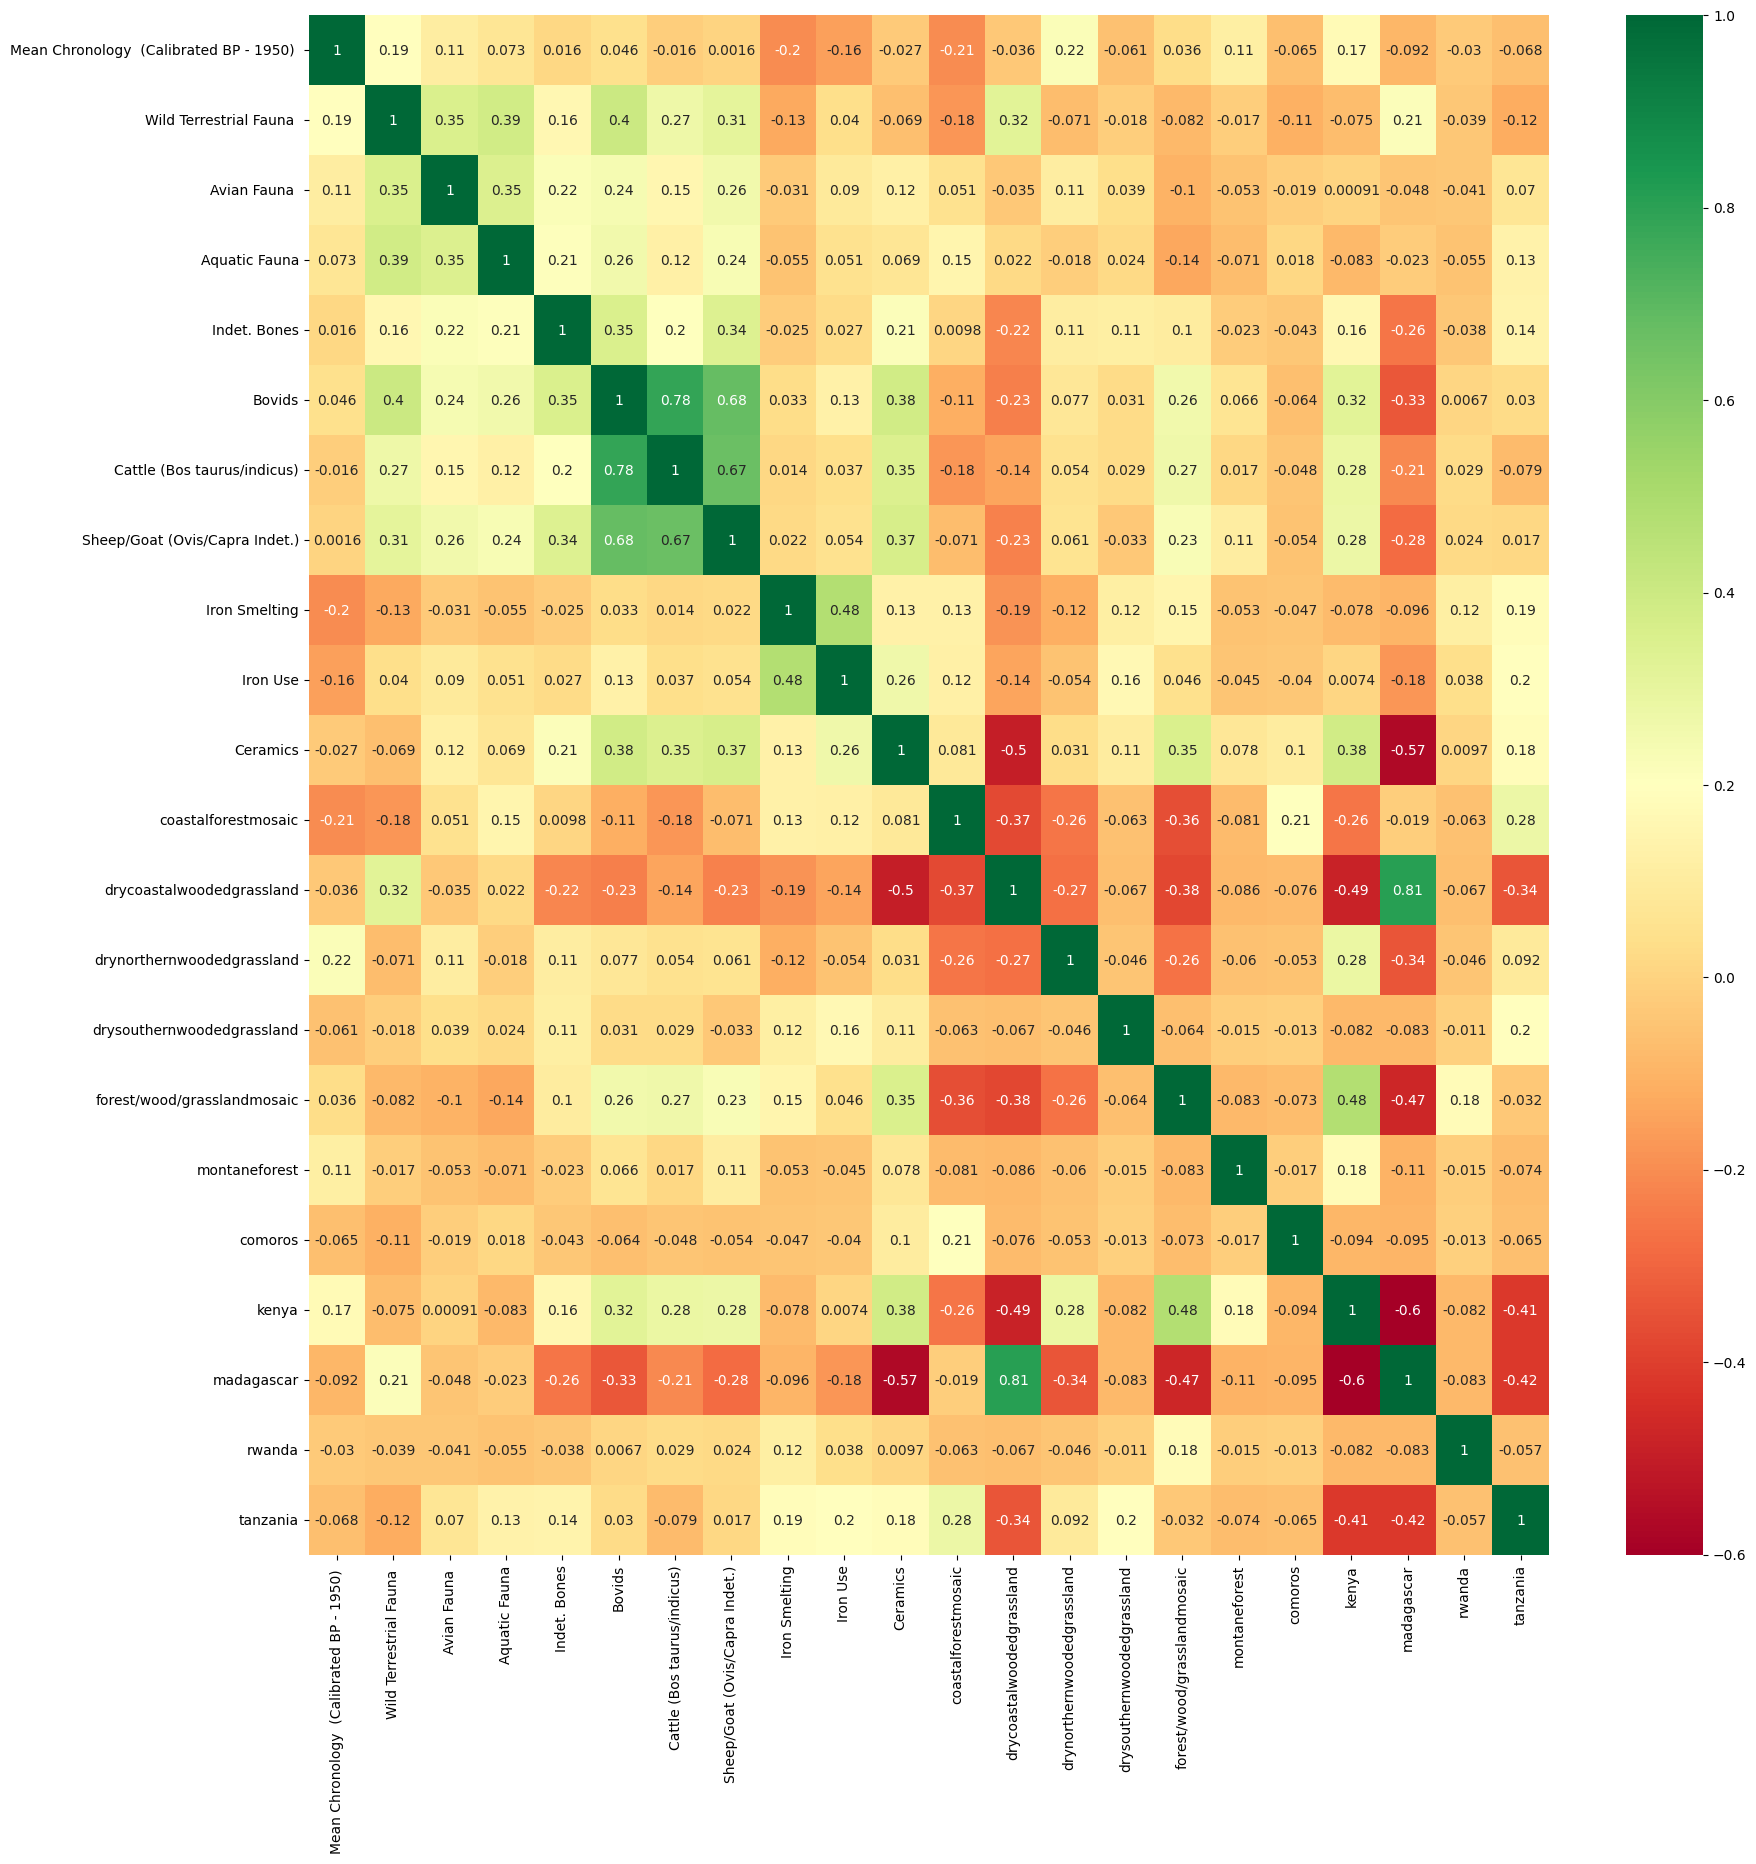

In [76]:
corrmat = df_countries.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))

# Plot heat map
g=sns.heatmap(df_countries[top_corr_features].corr(),annot=True,cmap="RdYlGn")

## Time to Apply ML to our Cleaned Data!
##### First we can separate our labels from our data

In [77]:
# set the  (the label we want to predict)
y = df_raw['Country']

# set the X (the features we want the algorithm to learn from)
X = df_raw.drop(columns=['Country'])


Now we have defined what to use as labels and features, it is time to make a test/train split in our data. We'll use a built-in function of `sklearn` to do this for us. We set `test_size` to 0.2, meaning that 20% of our data should be used as the test set.

In [78]:
# Use sklearn to automatically make a test/train set from our data
# In general 0.8/0.2 is the norm. But we have some extremely imbalanced labels, so let's use 60/40
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y)

In [79]:
Counter(y_test)

Counter({'madagascar': 271,
         'kenya': 267,
         'tanzania': 161,
         'comoros': 10,
         'rwanda': 8})

## Decision Tree

Now the data is prepared, we need to load a classifier from `sklearn`, and then train that classifier on our data.

It's time to break our our decision tree!

In [80]:
# Create Decision Tree classifier object
dt_clf = DecisionTreeClassifier(max_depth=3, class_weight='balanced')

# Train Decision Tree Classifier on our data
dt_clf = dt_clf.fit(X_train,y_train)

# Predict the labels on the test data
y_pred = dt_clf.predict(X_test)

# Show f1
print('accuracy score on test data:')
print(accuracy_score(y_test, y_pred))

accuracy score on test data:
0.5453277545327755


In [81]:
# use sklearn to view full classification report

# Precision = TP/(TP+FP)  Used to check the accuracy of positive predictions (think of targetting cancer cells in the brain)
# Recall = TP/(TP+FN)   Used to avoid missing too many positives (think of scanning for cancer cells in breast tissue)
# F1 score = A balance between precision and recall
# Support = Number of each class sampled for our test set

print('Classification report:')
print(classification_report(y_test,y_pred))


Classification report:
              precision    recall  f1-score   support

     comoros       0.08      1.00      0.14        10
       kenya       0.78      0.52      0.62       267
  madagascar       1.00      0.73      0.84       271
      rwanda       0.04      0.75      0.08         8
    tanzania       0.68      0.25      0.36       161

    accuracy                           0.55       717
   macro avg       0.51      0.65      0.41       717
weighted avg       0.82      0.55      0.63       717



## Visualizing our Decision Tree

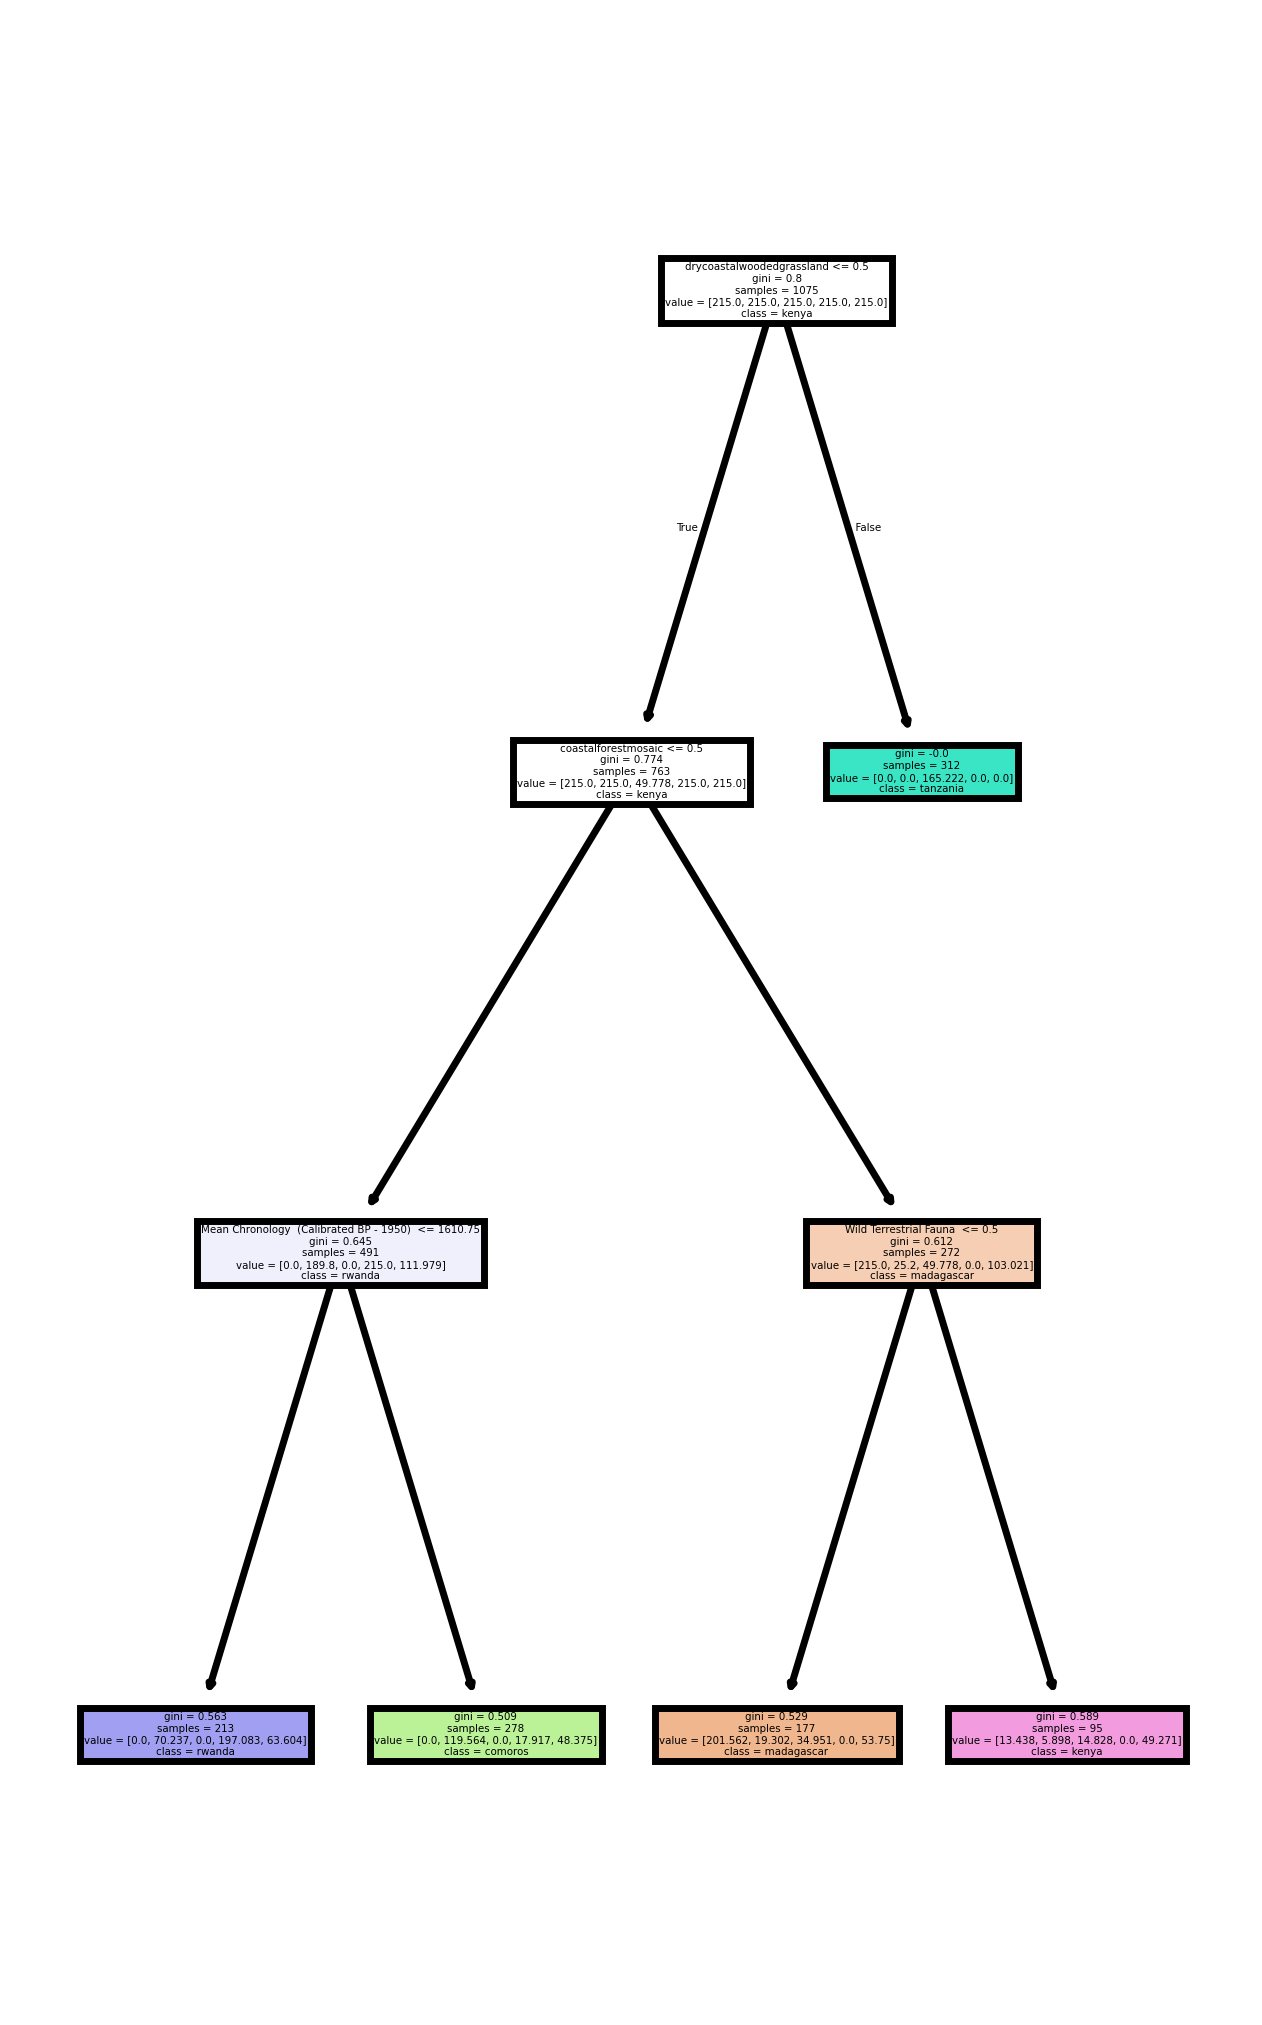

In [82]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (3,5), dpi=500)
tree.plot_tree(dt_clf,
           feature_names = X.keys(), 
           class_names=list(set(y)),
           filled = True);

## Deciding on Best Max Depth
##### Similar to what we did with SSE/Silhouette scores in KMeans, we can check different tree depths to find the best one

In [83]:
K = range(1,20)
scores = []


for k in K:
    # Create Decision Tree classifier object
    dt_clf = DecisionTreeClassifier(max_depth=k, class_weight='balanced')

    # Train Decision Tree Classifier on our data
    dt_clf = dt_clf.fit(X_train,y_train)

    # Predict the labels on the test data
    y_pred = dt_clf.predict(X_test)

    score = accuracy_score(y_test, y_pred)
    scores.append(score)

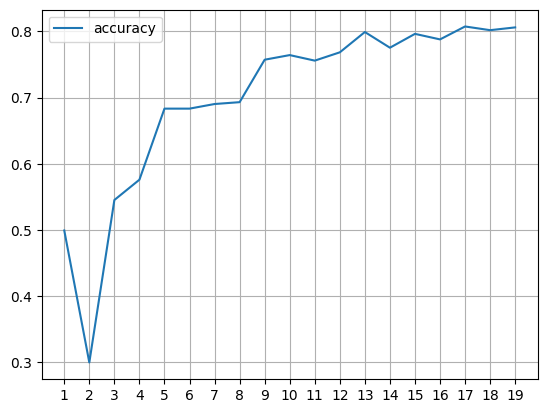

In [84]:
plt.plot(K, scores, label="accuracy")
plt.xticks(ticks=K)
plt.grid()
plt.legend()

##### We can also look at which classes were incorrectly classified as other classes using a confusion matrix

[[  2   3   3   0   0]
 [  5 222  38   1   1]
 [  5  44  96   4  12]
 [  0   1   6   2   1]
 [  0   4  11   0 256]]


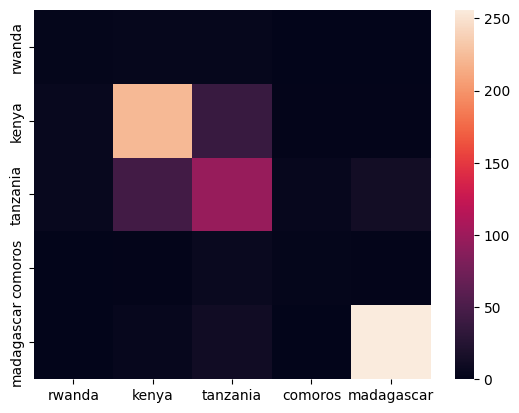

In [85]:
# make confusion table
confusion = confusion_matrix(y_test,y_pred, labels=y.unique())
print(confusion)

# make heatmap
sns.heatmap(confusion, xticklabels=y.unique(), yticklabels=y.unique())

# display the plot
plt.show()

## A Better way to do it: KFold Cross Validation
##### Whenever we split the dataset into test/train, we risk having an uneven samplings across our classes. KFold Cross Validation shuffles the dataset multiple times and splits it in different ways, then averages the accuracy to give a better idea of the true performance.
##### It's a great way to avoid overfitting

In [86]:
# import functions to do cross fold validation
from sklearn.model_selection import KFold, cross_val_score

In [ ]:
# set up the classifier 
dt_clf = DecisionTreeClassifier(max_depth=3, class_weight='balanced')

# set the number of folds
k_folds = KFold(n_splits = 4, shuffle=True)

# calculate the scores
scores = cross_val_score(dt_clf, X, y, cv = k_folds)

# print the scores
print("Cross Validation Scores: ", scores)
print("Average CV Score: ", scores.mean())
print("Standard deviation: ", scores.std())

In [ ]:
# As we saw before, we can try many different values for max_depth and see what works best

K = range(1,20)
scores = []

for k in K:
    # Create Decision Tree classifier object
    dt_clf = DecisionTreeClassifier(max_depth=k, class_weight='balanced')

    # Train Decision Tree Classifier on our data
    score = cross_val_score(dt_clf, X, y, cv = k_folds, random_state=0).mean()
    scores.append(score)

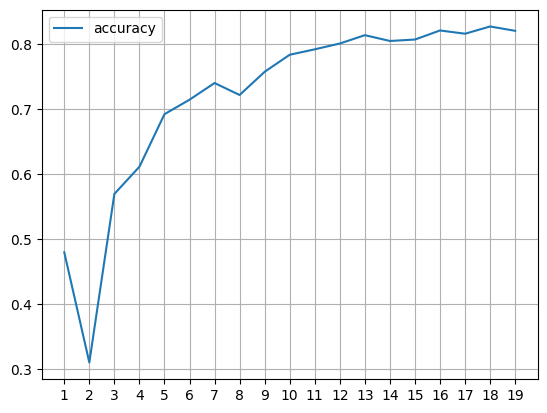

In [89]:
plt.plot(K, scores, label="accuracy")
plt.xticks(ticks=K)
plt.grid()
plt.legend()

# Exercises

## Exercise 1

##### We've now trained a decision tree to perform "Classification", in which the target feature we are trying to predict (y) contains a number of different classes (multiclass classification). In the case of a "yes-no" class (ie. Is the site in Rwanda?) we would refer to the problem as "binary classification".

##### But what if we want to predict a feature that is not made up of finite classes, but rather continuous values (ie Mean Chronology, which can be any year). This is called "Regression".

##### Let's try to use a Decision Tree to predict site dates based on the archaeological evidence we have (including which country the site is located - which was our prevoius target feature, but we will now use as our normal feature in X)

In [90]:
# Import the Decision Tree Regressor

from sklearn.tree import DecisionTreeRegressor

In [157]:
# To start, remember that you still have your cleaned dataframe (df)
# Start with this and then work through all the steps again (correlation map, KFold Cross Validation, etc.)

# set the  (the label we want to predict)
y = df_countries['Mean Chronology  (Calibrated BP - 1950) ']

# set the X (the features we want the algorithm to learn from)
X = df_countries.drop(columns=['Mean Chronology  (Calibrated BP - 1950) '])

In [158]:
# Use sklearn to automatically make a test/train set from our data
# In general 0.8/0.2 is the norm. But we have some extremely imbalanced labels, so let's use 60/40
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [192]:
K = range(1,20)
scores = []

k_folds = KFold(n_splits = 4, shuffle=True, random_state=0)

for k in K:
    # Create Decision Tree Regressor object
    dt_reg = DecisionTreeRegressor(max_depth=k, random_state=0)

    # Train Decision Tree Regressor on our data
    score = cross_val_score(dt_reg, X, y, scoring='neg_mean_absolute_error', cv = k_folds).mean()
    scores.append(score)

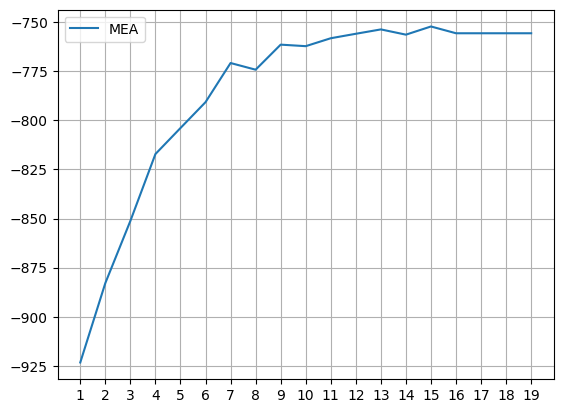

In [193]:
plt.plot(K, scores, label="MEA")
plt.xticks(ticks=K)
plt.grid()
plt.legend()

In [ ]:
# We don't seem able to push much beyond a MAE of about 750 years.
# In the next class we'll see how to go a little bit furhter, but it seems in general our dataset simply doesn't have enough info.
# That is, the information we have about sites is not very chronologically specific.